In [702]:
import pandas as pd
import seaborn as sns
import statistics as sts
import numpy as np
import matplotlib.pyplot as plt
import squarify
from factor_analyzer import FactorAnalyzer
import pingouin as pg
import kneed as kd

In [149]:
dataset = pd.read_csv('Desktop/IFOOD/ifood-data-business-analyst-test-master/ifood-data-business-analyst-test-master/ml_project1_data.csv')

### Cleaning, Fixing and Modelling 

Firstly let's run some checks to see if there's any problem in our database

In [150]:
#dataset.info() #Identified null values at Income column and there's 2 extra columns that the file description didnt mention
dataset[dataset['ID'].duplicated(keep=False)] #no duplicates
dataset[['Z_CostContact','Z_Revenue']] #theyre both a single value column. It 
                                       #can be used to estimate costs and revenue when used with the Campaign flag columns

#Fixing
dataset['Income'].fillna(sts.median(dataset['Income']), inplace=True) #replace null income by median income
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Ok! Now lets dig in into the other variable and try to extract some values from it. At first, I will focus on numerals.

In [151]:
#Before we start exploring our database and actually extract some useful insights we must first create some new columns
#that will help us guide our modelling ahead

#Lets create a profit column for customers
dataset['Revenue'] = (
                    dataset['AcceptedCmp1'] + dataset['AcceptedCmp2'] 
                     + dataset['AcceptedCmp3'] + dataset['AcceptedCmp4'] 
                     + dataset['AcceptedCmp5'] + dataset['Response']
                    ) * dataset['Z_Revenue']

dataset['CashIn'] = (((
                    dataset['AcceptedCmp1'] + dataset['AcceptedCmp2'] 
                     + dataset['AcceptedCmp3'] + dataset['AcceptedCmp4'] 
                     + dataset['AcceptedCmp5'] + dataset['Response']
                    ) * dataset['Z_Revenue']) - (6 * dataset['Z_CostContact']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [152]:
#Now lets aglomerate the amount spent and number of purchases

dataset['Spend'] = dataset['MntWines'] + dataset['MntFruits'] + dataset['MntMeatProducts'] + dataset['MntFishProducts'] + dataset['MntSweetProducts'] + dataset['MntGoldProds']
    
dataset['Purchases'] = dataset['NumDealsPurchases'] + dataset['NumWebPurchases'] + dataset['NumCatalogPurchases']+ dataset['NumStorePurchases'] + dataset['NumWebVisitsMonth']

dataset['AOV'] = dataset['Spend']/dataset['Purchases']

dataset['AOV'] = dataset['AOV'].round(2)

#Now lets check our data
#sns.boxplot(dataset['Spend']) #We got some outliers and therefore it will be adjusted
spend=dataset['Spend']
Q1 = spend.quantile(0.25)
Q3 = spend.quantile(0.75)
IQR = Q3-Q1
maximum = (Q3+1.5*IQR)
spend[spend > maximum] = maximum
dataset['Spend'] = spend
#print(sns.boxplot(x=dataset['Spend']))

#print(sns.boxplot(x=dataset['Purchases'])) #Same thing happened to Purchases. We wil replace the outliers
purchase=dataset['Purchases']
Q1 = purchase.quantile(0.25)
Q3 = purchase.quantile(0.75)
IQR = Q3-Q1
maximum = (Q3+1.5*IQR)
purchase[purchase > maximum] = maximum
dataset['Purchases'] = purchase
#print(sns.boxplot(x=dataset['Purchases']))

<ipython-input-152-2f2d49c8cb24>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend[spend > maximum] = maximum
<ipython-input-152-2f2d49c8cb24>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase[purchase > maximum] = maximum


In [153]:
#The date that the customer joined us doesnt tell us much.. Let' use: years of relationships
from datetime import date

dataset['Dt_Customer'] = pd.to_datetime(dataset['Dt_Customer'], format='%Y-%m-%d')
dataset['Relationship'] = (pd.to_datetime(str(date.today())) - dataset['Dt_Customer']) / np.timedelta64(1,'Y')
dataset['Relationship'] = dataset['Relationship'].round().astype('int64')

#Lets have a look at our customer age

dataset['Age'] = pd.to_datetime(dataset['Year_Birth'], format='%Y')
dataset['Age'] = (pd.to_datetime(str(date.today())) - dataset['Age']) / np.timedelta64(1,'Y')
dataset['Age'] = dataset['Age'].round().astype('int64')
dataset[['Relationship','Age']]

#Lets look at our columns
#print(sns.boxplot(dataset['Age'])
age = dataset['Age']
Q1 = age.quantile(0.25)
Q3 = age.quantile(0.75)
IQR = Q3-Q1
maximum = (Q3+1.5*IQR)
age = age[age < maximum] #Since theyre too old the other columns may be as well deviated therefore i will exclude them
dataset = dataset[dataset['Age'] < maximum]

AxesSubplot(0.125,0.125;0.775x0.755)
The skewness is 0.11


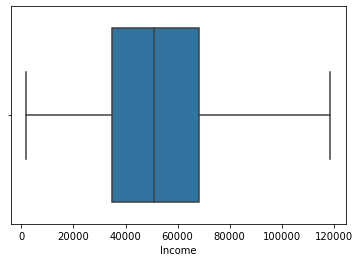

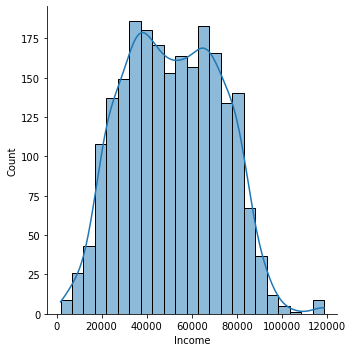

In [154]:
#Ok, the last step in this chapter is to create new categories based on Income ranges

income = dataset['Income']

#print(sns.boxplot(income)) #Theres some values above the 3th quarter. Lets replace them and remake our boxplot

Q1 = income.quantile(0.25)
Q3 = income.quantile(0.75)
IQR = Q3-Q1
maximum = (Q3+1.5*IQR)
income[income > maximum] = maximum

dataset['Income'] = income
print(sns.boxplot(x=dataset['Income']))
print(sns.displot(dataset, x=dataset['Income'], kde=True)) #It looks close to a normal distribution! But we will further categorize it
print('The skewness is '+str(dataset['Income'].skew().round(2))) #Our skewness is pretty good already!

Now that we dealt with the outliers in our Income column, we must proceed and create new columns related to it.

Income = Anual Salary = Sum of monthly incomes 

Income per Capita = Household Income / household members

This information may come in handy when we start clustering our customers using the Income column. Why? Annual Income for a single guy feels differen than an annual income divided in a house of 4.

In [155]:
#Creating monthly Income
dataset['MonthlyIncome'] = dataset['Income']/12
dataset['MonthlyIncome'] = dataset['MonthlyIncome'].round().astype('int64')
dataset['MonthlyIncome'].describe()

#Creating income per capita

#Creating flag to check if the person is in a relationship or not
dataset.loc[(dataset['Marital_Status'] == 'Single') |
            (dataset['Marital_Status'] == 'Divorced') |
            (dataset['Marital_Status'] == 'Widow') |
            (dataset['Marital_Status'] == 'Alone') |
            (dataset['Marital_Status'] == 'Absurd') |
            (dataset['Marital_Status'] == 'YOLO'), 'MaritalSup'] = 0 

dataset.loc[(dataset['Marital_Status'] == 'Together') |
            (dataset['Marital_Status'] == 'Married'), 'MaritalSup'] = 1

dataset['HouseholdSize'] = (dataset['MaritalSup'].astype('int64') + dataset['Kidhome'] + dataset['Teenhome']+1)
dataset['IncomePerCapita'] = dataset['Income'] / dataset['HouseholdSize']
dataset['IncomePerCapita'] = dataset['IncomePerCapita'].round().astype('int64')

dataset = dataset.drop(columns=['MaritalSup'])

dataset

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Revenue,CashIn,Spend,Purchases,AOV,Relationship,Age,MonthlyIncome,HouseholdSize,IncomePerCapita
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,11,-7,1617.0,32.0,50.53,9,65,4845,1,58138
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,-18,27.0,11.0,2.45,7,68,3862,3,15448
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,-18,776.0,25.0,31.04,8,57,5968,2,35806
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,-18,53.0,14.0,3.79,7,38,2220,3,8882
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,-18,422.0,24.0,17.58,8,41,4858,3,19431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,0,-18,1341.0,23.0,58.30,8,55,5102,3,20408
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,11,-7,444.0,29.0,15.31,7,76,5334,5,12803
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,11,-7,1241.0,25.0,49.64,8,41,4748,1,56981
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,0,-18,843.0,26.0,32.42,8,66,5770,3,23082


In [156]:
#Now lets give an attention back to our campaigns... Id like to know the engagement based on conversion ratio..
dataset['SocialEngagement'] = dataset['AcceptedCmp1']+dataset['AcceptedCmp2']+dataset['AcceptedCmp3']+dataset['AcceptedCmp4']+dataset['AcceptedCmp5']+dataset['Response']
dataset['SocialEngagement'] = (dataset['SocialEngagement']/6).round(2)
dataset['SocialEngagement']

0       0.17
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
2235    0.00
2236    0.17
2237    0.17
2238    0.00
2239    0.17
Name: SocialEngagement, Length: 2237, dtype: float64

# Who's in my database? (EDA)

At first I'd like to check the informations given in the pdf file and start our thesis from there

In [11]:
last = dataset[['ID','Response']].groupby('Response').count().reset_index()
last['Cost'] = dataset[['Response','Z_CostContact']].groupby('Response').sum()
last['Revenue'] = dataset[['Response','Z_Revenue']].groupby('Response').sum()
last['Percent'] = (last['ID']/last['ID'].sum()).map('{:,.2%}'.format)

last = last.rename(columns={'Response':'Converted'})

last.loc[last['Converted'] == 1, 'ROI'] = last['Revenue'] - last['Cost']
last.loc[last['Converted'] == 0, 'ROI'] = last['Cost'] *-1

last

,Converted,ID,Cost,Revenue,Percent,ROI
0,0,1906,5718,20966,85.09%,-5718.0
1,1,334,1002,3674,14.91%,2672.0


In [12]:
#Just for curiosity - and also for future usage: let's see the conversion percentage of the other campaigns

cmp1 = dataset[['ID','AcceptedCmp1']].groupby('AcceptedCmp1').count().reset_index()
cmp1['Cost'] = dataset[['AcceptedCmp1','Z_CostContact']].groupby('AcceptedCmp1').sum()
cmp1['Revenue'] = dataset[['AcceptedCmp1','Z_Revenue']].groupby('AcceptedCmp1').sum()
cmp1['Percent'] = (cmp1['ID']/cmp1['ID'].sum()).map('{:,.2%}'.format)
cmp1 = cmp1.rename(columns={'AcceptedCmp1':'Converted'})
cmp1.loc[last['Converted'] == 1, 'ROI'] = cmp1['Revenue'] - cmp1['Cost']
cmp1.loc[last['Converted'] == 0, 'ROI'] = cmp1['Cost'] *-1

cmp2 = dataset[['ID','AcceptedCmp2']].groupby('AcceptedCmp2').count().reset_index()
cmp2['Cost'] = dataset[['AcceptedCmp2','Z_CostContact']].groupby('AcceptedCmp2').sum()
cmp2['Revenue'] = dataset[['AcceptedCmp2','Z_Revenue']].groupby('AcceptedCmp2').sum()
cmp2['Percent'] = (cmp2['ID']/cmp2['ID'].sum()).map('{:,.2%}'.format)
cmp2 = cmp2.rename(columns={'AcceptedCmp2':'Converted'})
cmp2.loc[last['Converted'] == 1, 'ROI'] = cmp2['Revenue'] - cmp2['Cost']
cmp2.loc[last['Converted'] == 0, 'ROI'] = cmp2['Cost'] *-1

cmp3 = dataset[['ID','AcceptedCmp3']].groupby('AcceptedCmp3').count().reset_index()
cmp3['Cost'] = dataset[['AcceptedCmp3','Z_CostContact']].groupby('AcceptedCmp3').sum()
cmp3['Revenue'] = dataset[['AcceptedCmp3','Z_Revenue']].groupby('AcceptedCmp3').sum()
cmp3['Percent'] = (cmp3['ID']/cmp3['ID'].sum()).map('{:,.2%}'.format)
cmp3 = cmp3.rename(columns={'AcceptedCmp3':'Converted'})
cmp3.loc[last['Converted'] == 1, 'ROI'] = cmp3['Revenue'] - cmp3['Cost']
cmp3.loc[last['Converted'] == 0, 'ROI'] = cmp3['Cost'] *-1

cmp4 = dataset[['ID','AcceptedCmp4']].groupby('AcceptedCmp4').count().reset_index()
cmp4['Cost'] = dataset[['AcceptedCmp4','Z_CostContact']].groupby('AcceptedCmp4').sum()
cmp4['Revenue'] = dataset[['AcceptedCmp4','Z_Revenue']].groupby('AcceptedCmp4').sum()
cmp4['Percent'] = (cmp2['ID']/cmp2['ID'].sum()).map('{:,.2%}'.format)
cmp4 = cmp4.rename(columns={'AcceptedCmp4':'Converted'})
cmp4.loc[last['Converted'] == 1, 'ROI'] = cmp4['Revenue'] - cmp4['Cost']
cmp4.loc[last['Converted'] == 0, 'ROI'] = cmp4['Cost'] *-1

cmp5 = dataset[['ID','AcceptedCmp5']].groupby('AcceptedCmp5').count().reset_index()
cmp5['Cost'] = dataset[['AcceptedCmp5','Z_CostContact']].groupby('AcceptedCmp5').sum()
cmp5['Revenue'] = dataset[['AcceptedCmp5','Z_Revenue']].groupby('AcceptedCmp5').sum()
cmp5['Percent'] = (cmp5['ID']/cmp5['ID'].sum()).map('{:,.2%}'.format)
cmp5 = cmp5.rename(columns={'AcceptedCmp5':'Converted'})
cmp5.loc[last['Converted'] == 1, 'ROI'] = cmp5['Revenue'] - cmp5['Cost']
cmp5.loc[last['Converted'] == 0, 'ROI'] = cmp5['Cost'] *-1

print(cmp1)
print(cmp2)
print(cmp3)
print(cmp4)
print(cmp5)
print(last)

print('A conversao média é '+ str(sts.mean([6.43,1.34,7.28,1.3,7.28])))
print('A conversao mediana é ' + str(sts.median([6.43,1.34,7.28,1.34,7.28])))

   Converted    ID  Cost  Revenue Percent     ROI
0          0  2096  6288    23056  93.57% -6288.0
1          1   144   432     1584   6.43%  1152.0
   Converted    ID  Cost  Revenue Percent     ROI
0          0  2210  6630    24310  98.66% -6630.0
1          1    30    90      330   1.34%   240.0
   Converted    ID  Cost  Revenue Percent     ROI
0          0  2077  6231    22847  92.72% -6231.0
1          1   163   489     1793   7.28%  1304.0
   Converted    ID  Cost  Revenue Percent     ROI
0          0  2073  6219    22803  98.66% -6219.0
1          1   167   501     1837   1.34%  1336.0
   Converted    ID  Cost  Revenue Percent     ROI
0          0  2077  6231    22847  92.72% -6231.0
1          1   163   489     1793   7.28%  1304.0
   Converted    ID  Cost  Revenue Percent     ROI
0          0  1906  5718    20966  85.09% -5718.0
1          1   334  1002     3674  14.91%  2672.0
A conversao média é 4.726
A conversao mediana é 6.43


Ok, just as the file description said the conversion in the last campaign was ~15% and the Revenue and Costs envolved about the same.

Taking a look at the conversion rate of the previous campaigns we can see that this last one had an increase of ~+11p.p. Ok, now that we have this information we know that the secret for monetization is not in those that didnt convert in the last campaign.

In order to understand this problem I could face it by starting my analysis from the bottom (who converted -> who's him in my database) or top-bottom (who is my database -> who converted). In order to build a solid concept of this analysis in our heads, I will choose to start my analysis by the first option, and then we will come back to this step in order to understand who's the ones that converted.

In [157]:
#Lets split our dataset. I wanna have a second dataset with the non-original columns
dts = dataset
dts = dts.drop(columns=['Year_Birth','Marital_Status','Dt_Customer','Z_CostContact','Z_Revenue'])

#Now lets have a broad view in our correlation table
dts.corr().style.background_gradient(cmap='Blues')

,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Revenue,CashIn,Spend,Purchases,AOV,Relationship,Age,MonthlyIncome,HouseholdSize,IncomePerCapita,SocialEngagement
ID,1.000000,0.001326,0.002202,-0.003543,-0.046755,-0.021181,0.007080,-0.002622,-0.023181,-0.006444,-0.010661,-0.036917,-0.017913,-0.001893,-0.014062,-0.008104,-0.035959,-0.025292,-0.005062,-0.021524,-0.015027,0.031520,-0.021810,-0.036025,-0.036025,-0.015819,-0.025732,0.009474,0.014027,-0.003024,0.001331,0.010175,-0.005301,-0.035982
Income,0.001326,1.000000,-0.519025,0.033480,0.001627,0.701643,0.515171,0.676751,0.529711,0.525308,0.389919,-0.114340,0.463415,0.687554,0.647753,-0.639830,-0.009798,0.218405,0.401587,0.328780,0.107449,-0.026334,0.169228,0.350596,0.350596,0.798016,0.498547,0.446401,-0.026846,0.199718,1.000000,-0.290348,0.735730,0.350942
Kidhome,0.002202,-0.519025,1.000000,-0.035753,0.007544,-0.496367,-0.372488,-0.437059,-0.387536,-0.370656,-0.349633,0.221799,-0.362063,-0.502438,-0.500387,0.447641,0.014606,-0.161775,-0.204994,-0.172512,-0.081794,0.036283,-0.080176,-0.193287,-0.193287,-0.556931,-0.355826,-0.340343,-0.055579,-0.234133,-0.519028,0.584661,-0.531107,-0.193494
Teenhome,-0.003543,0.033480,-0.035753,1.000000,0.017115,0.005409,-0.175951,-0.260820,-0.203900,-0.162218,-0.020186,0.387792,0.155776,-0.110285,0.050517,0.134491,-0.042823,0.038790,-0.190227,-0.140288,-0.015664,0.007591,-0.154730,-0.158979,-0.158979,-0.137753,0.185644,-0.140165,0.016923,0.363350,0.033479,0.595437,-0.328097,-0.158928
Recency,-0.046755,0.001627,0.007544,0.017115,1.000000,0.016668,-0.003592,0.023705,0.001532,0.023045,0.017412,-0.000987,-0.010616,0.025449,0.001117,-0.021959,-0.032976,0.018890,0.000956,-0.019258,-0.001764,0.005398,-0.198568,-0.088749,-0.088749,0.021212,-0.000986,0.014850,0.027622,0.019670,0.001628,0.012709,0.011376,-0.088691
MntWines,-0.021181,0.701643,-0.496367,0.005409,0.016668,1.000000,0.388518,0.561993,0.399073,0.385992,0.386376,0.010829,0.542177,0.634784,0.642433,-0.320337,0.062201,0.373532,0.471969,0.354365,0.206040,-0.035930,0.247392,0.488908,0.488908,0.891741,0.645244,0.465243,0.151295,0.163035,0.701638,-0.295306,0.549656,0.489084
MntFruits,0.007080,0.515171,-0.372488,-0.175951,-0.003592,0.388518,1.000000,0.542057,0.594438,0.567054,0.390042,-0.131886,0.297024,0.487307,0.463168,-0.417427,0.014983,0.010402,0.212027,0.195380,-0.009701,-0.002800,0.125904,0.172083,0.172083,0.613096,0.341910,0.349997,0.078665,0.013751,0.515172,-0.340504,0.490283,0.172338
MntMeatProducts,-0.002622,0.676751,-0.437059,-0.260820,0.023705,0.561993,0.542057,1.000000,0.567880,0.523418,0.348845,-0.122465,0.293579,0.723519,0.480110,-0.539203,0.018331,0.103053,0.372212,0.310096,0.043090,-0.020720,0.236640,0.329733,0.329733,0.842639,0.402895,0.600274,0.082893,0.030927,0.676751,-0.427065,0.666704,0.330234
MntFishProducts,-0.023181,0.529711,-0.387536,-0.203900,0.001532,0.399073,0.594438,0.567880,1.000000,0.579553,0.422103,-0.139440,0.293489,0.534033,0.460099,-0.445760,0.000370,0.016864,0.198163,0.260908,0.002583,-0.018818,0.111415,0.179535,0.179535,0.642426,0.346111,0.371451,0.074974,0.042519,0.529716,-0.361996,0.509161,0.179829
MntSweetProducts,-0.006444,0.525308,-0.370656,-0.162218,0.023045,0.385992,0.567054,0.523418,0.579553,1.000000,0.369193,-0.120278,0.348304,0.490497,0.448801,-0.423249,0.001491,0.028612,0.258848,0.241875,0.009972,-0.020404,0.117366,0.199077,0.199077,0.602671,0.357241,0.339196,0.080266,0.019571,0.525308,-0.328128,0.497205,0.199285


Income -> Basically theres a correlation between purchasing and income power. 
Kids -> Weak factor for Web Visits

Wine -> Very strong correlation with Spend, Purchase and Income. Medium Social Engagement. Medium NumCatalog and NumStore.
Fruits -> 65% corre with Spend
Meat -> Strong correlation with Spend and NumCatalog.

NumWebPurchase -> Strong correlation with Purchase
NumCatalog -> Good correlation with Spend and Income
NumStore -> Good correlation with Purchase and Income

NumWebVisits -> Good negative correlation with Income

Cmp5 -> Good correlation with Revenue and CashIn
Cmp1 -> Good correlation with Revenue and CashIn
Response -> Good correlation with Revenue and CashIn

Revenue -> Good correlation with Cmp5 and Response
CashIn -> Good correlation with Cmp5 and Response

Spend -> Strong correlation with Wine and Meat. Good correlation with Catalog.
Purchases -> Strong correlation with WebPurchases. Good correlation with StorePurchases.
AOV -> Weak correlation with MeatProducts

MonthlyIncome -> Good Negative correlation with WebVisits
IncomePerCapita -> Good correlation with Spend. 

SocialEngagement -> Very strong correlation with Revenue and CashIn. Strong correlation with Response.

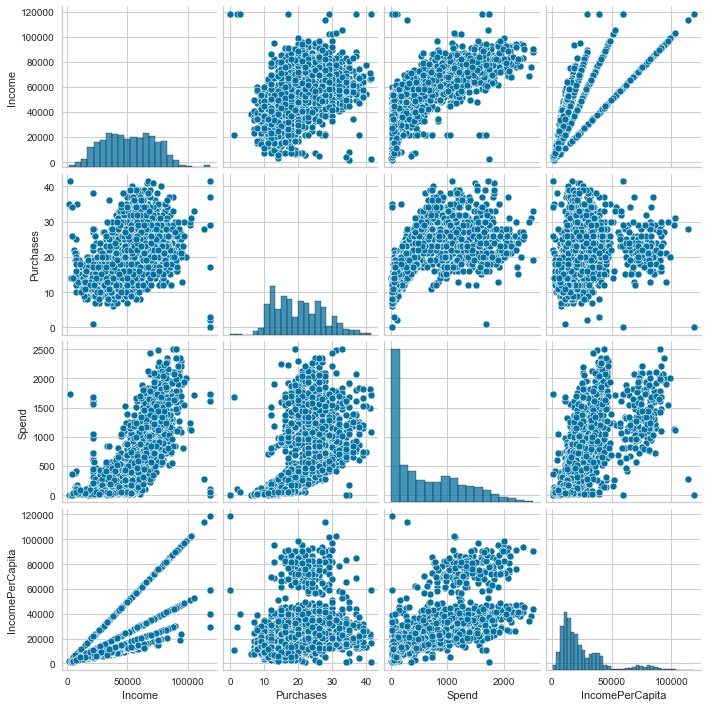

In [1179]:
sns.pairplot(cus, vars=['Income','Purchases','Spend','IncomePerCapita'], markers=['o','s'])

#It looks close to a normal distribution! But we will further categorize it

## What's the Customer Characteristics? 

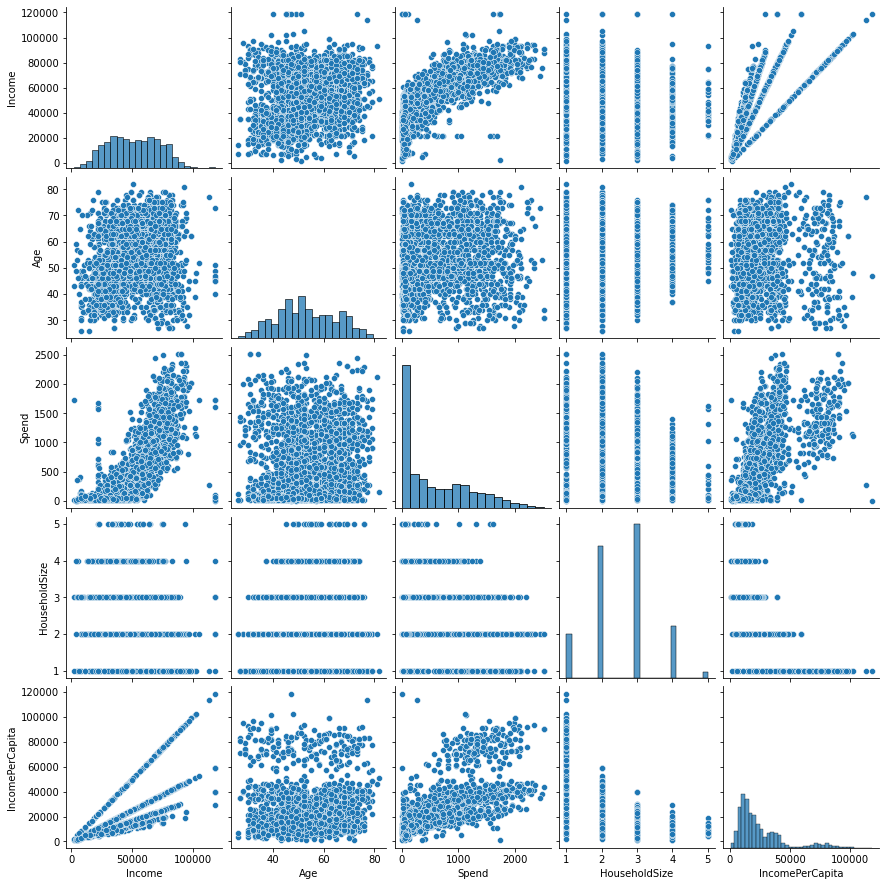

In [566]:
cus = dts
sns.pairplot(cus, vars=['Income','Age','Spend','HouseholdSize','IncomePerCapita'], markers=['o','s'])


#### Age Range

<AxesSubplot:ylabel='Age'>

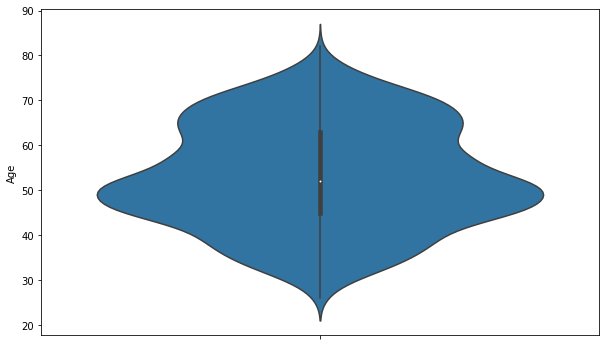

In [569]:
plt.figure(figsize=(10,6))
sns.violinplot(y=cus["Age"])

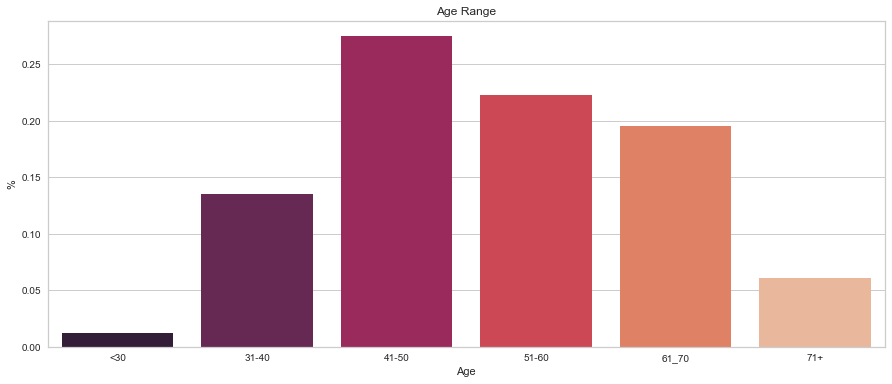

count    2237.000000
mean       53.098346
std        11.701917
min        26.000000
25%        45.000000
50%        52.000000
75%        63.000000
max        82.000000
Name: Age, dtype: float64

In [1547]:
age20_30= cus.Age[(cus.Age <=30)]
age31_40= cus.Age[(cus.Age >31) & (cus.Age <=40)]
age41_50= cus.Age[(cus.Age >41) & (cus.Age <=50)]
age51_60= cus.Age[(cus.Age >51) & (cus.Age <=60)]
age61_70= cus.Age[(cus.Age >61) & (cus.Age <=70)] 
age71= cus.Age[(cus.Age >71)]

x = ['<30','31-40','41-50','51-60','61_70','71+']
y = [len(age20_30.values)/ cus['Age'].count(),len(age31_40.values)/ cus['Age'].count(),
     len(age41_50.values)/ cus['Age'].count(),len(age51_60.values)/ cus['Age'].count(),
     len(age61_70.values)/ cus['Age'].count(),len(age71.values)/ cus['Age'].count()]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Age Range")
plt.xlabel("Age")
plt.ylabel("%")
plt.show()

cus['Age'].describe()

We have a matured public in our database. The majority of our clients lies between 41 and 60 years old, mean = 53 and median = 52. I suspect that this public is averse to online purchasing, a hypothesis to be validated after.

#### Education Range

    Education    ID   Percent
0    2n Cycle   201  0.089852
1       Basic    54  0.024139
2  Graduation  1127  0.503800
3      Master   370  0.165400
4         PhD   485  0.216808


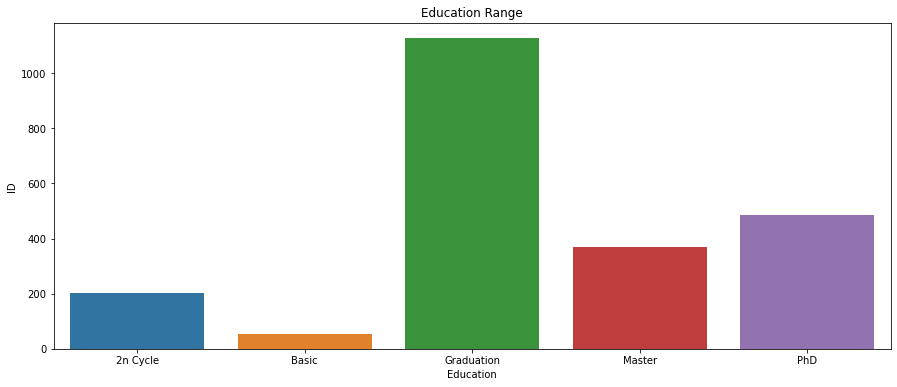

In [617]:
ed = cus[['Education','ID']].groupby('Education').count().reset_index()
ed['Percent'] = (ed['ID']/ed['ID'].sum())

print(ed.head())

plt.figure(figsize=(15,6))
plt.title('Education Range')
sns.barplot(x=ed['Education'],y=ed['ID'])
plt.show()

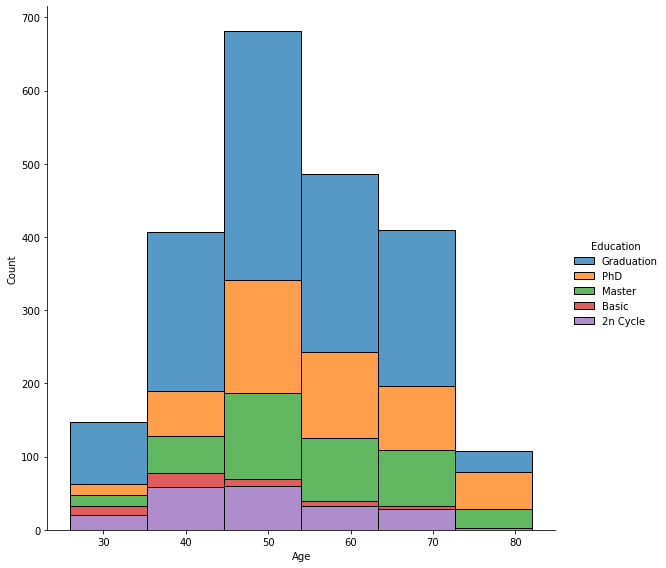

In [632]:
sns.displot(data=cus,x=cus['Age'],hue='Education',multiple='stack',bins=6,height=8)

The vast majority in our base have graduated from university followed by PhD and Master. The distribution of education levels between age looks quite similar among the bins.

#### Recency 

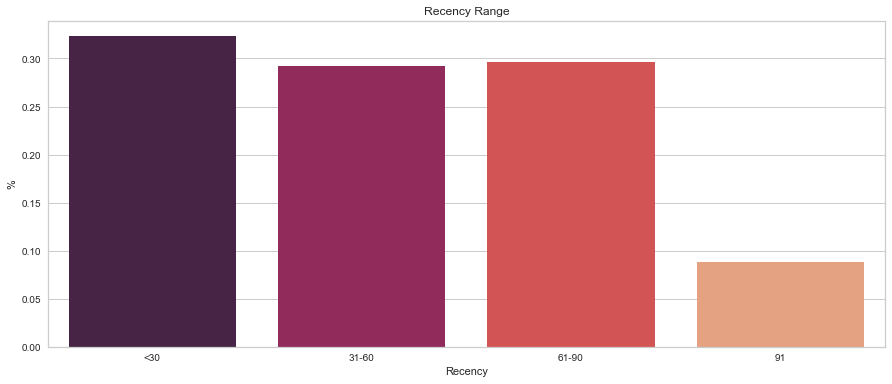

count    2237.000000
mean       49.104604
std        28.956073
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Recency, dtype: float64

In [1569]:
rec30= cus.Recency[(cus.Recency <=30)]
rec31_60= cus.Recency[(cus.Recency >=31) & (cus.Recency <=60)]
rec61_90= cus.Recency[(cus.Recency >=61) & (cus.Recency <=90)]
rec91= cus.Recency[(cus.Recency >=91)]

x = ['<30','31-60','61-90','91']
y = [len(rec30.values)/ cus['Recency'].count(),len(rec31_60.values)/ cus['Recency'].count(),
     len(rec61_90.values)/ cus['Recency'].count(),len(rec91.values)/ cus['Recency'].count(),
     ]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Recency Range")
plt.xlabel("Recency")
plt.ylabel("%")
plt.show()

cus['Recency'].describe()

#### Household

   HouseholdSize   ID   Percent
0              1  254  0.113545
1              2  761  0.340188
2              3  889  0.397407
3              4  301  0.134555
4              5   32  0.014305


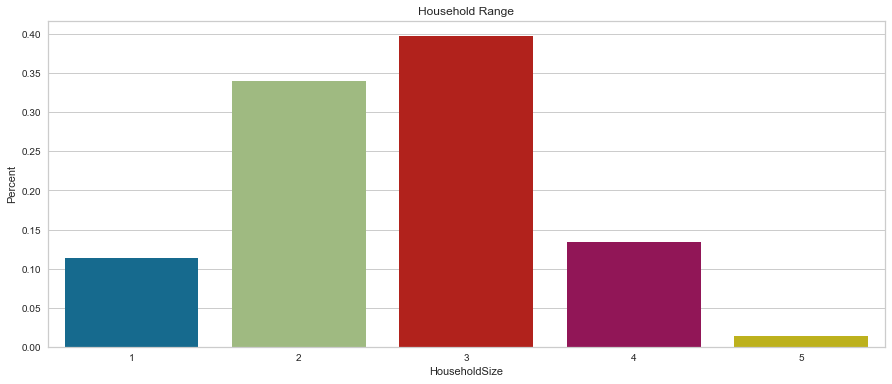

In [1576]:
hh = cus[['HouseholdSize','ID']].groupby('HouseholdSize').count().reset_index()
hh['Percent'] = (hh['ID']/hh['ID'].sum())

print(hh.head())

plt.figure(figsize=(15,6))
plt.title('Household Range')
sns.barplot(x=hh['HouseholdSize'],y=hh['Percent'])
plt.show()

#Lembrando que estou contando a propria pessoa como membro do Household.
#Quem mora com ela = HouseholdSize - 1

#### Economics 

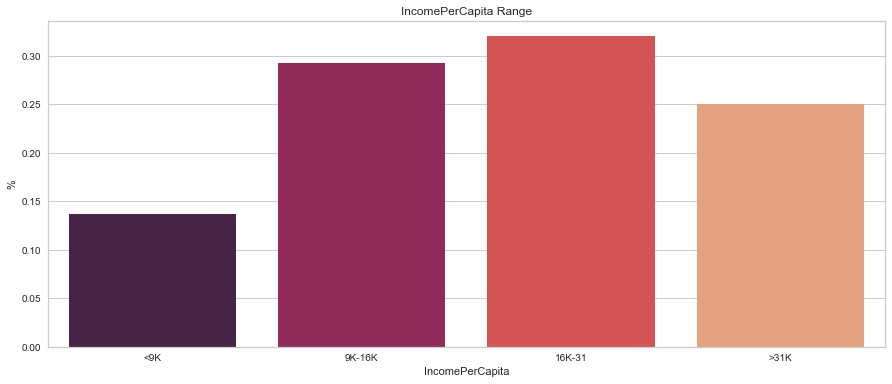

count      2237.000000
mean      24674.960662
std       19305.819846
min         816.000000
25%       11953.000000
50%       18488.000000
75%       31905.000000
max      118646.000000
Name: IncomePerCapita, dtype: float64

In [1605]:
ax1= cus.IncomePerCapita[(cus.IncomePerCapita <=(18488.0/2))]
ax2= cus.IncomePerCapita[(cus.IncomePerCapita >(18488.0/2)) & (cus.IncomePerCapita <=(31905.0/2))]
ax3= cus.IncomePerCapita[(cus.IncomePerCapita >(31905.0/2)) & (cus.IncomePerCapita <=(31905.0))]
ax4= cus.IncomePerCapita[(cus.IncomePerCapita >(31905.0))]

x = ['<9K','9K-16K','16K-31','>31K']
y = [len(ax1.values)/ cus['IncomePerCapita'].count(),len(ax2.values)/ cus['IncomePerCapita'].count(),
     len(ax3.values)/ cus['IncomePerCapita'].count(),len(ax4.values)/ cus['IncomePerCapita'].count(),
     ]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("IncomePerCapita Range")
plt.xlabel("IncomePerCapita")
plt.ylabel("%")
plt.show()

cus['IncomePerCapita'].describe()

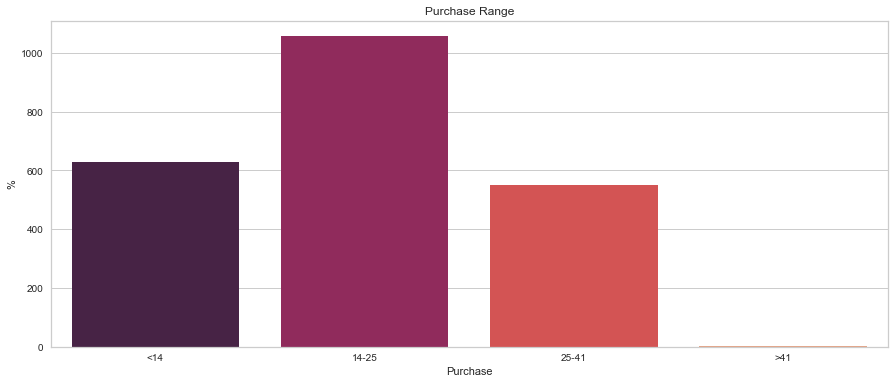

count    2237.000000
mean       20.185740
std         7.277055
min         0.000000
25%        14.000000
50%        19.000000
75%        25.000000
max        41.500000
Name: Purchases, dtype: float64

In [1615]:
ax1= cus.Purchases[(cus.Purchases <=(14.0))]
ax2= cus.Purchases[(cus.Purchases >(14.0)) & (cus.Purchases <=(25.0))]
ax3= cus.Purchases[(cus.Purchases >(25.0)) & (cus.Purchases <=(41.0))]
ax4= cus.Purchases[(cus.Purchases >(41.0))]

x = ['<14','14-25','25-41','>41']
y = [len(ax1.values),len(ax2.values),
     len(ax3.values),len(ax4.values),
     ]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Purchase Range")
plt.xlabel("Purchase")
plt.ylabel("%")
plt.show()

cus['IncomePerCapita'].describe()

cus['Purchases'].describe()

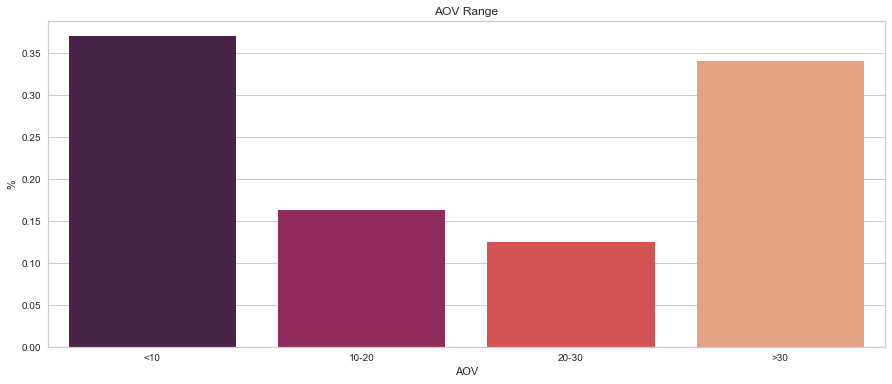

count    2237.0
mean        inf
std         NaN
min         1.0
25%         6.0
50%        18.0
75%        40.0
max         inf
dtype: float64

In [1621]:
aov = (cus['Spend']/cus['Purchases']+1).round(0)

ax1= aov[(aov <=(10.0))]
ax2= aov[(aov >(10.0)) & (aov <=(20.0))]
ax3= aov[(aov >(20.0)) & (aov <=(30.0))]
ax4= aov[(aov >(30.0))]

x = ['<10','10-20','20-30','>30']
y = [len(ax1.values)/ cus['IncomePerCapita'].count(),len(ax2.values)/ cus['IncomePerCapita'].count(),
     len(ax3.values)/ cus['IncomePerCapita'].count(),len(ax4.values)/ cus['IncomePerCapita'].count(),
     ]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("AOV Range")
plt.xlabel("AOV")
plt.ylabel("%")
plt.show()

aov.describe()

# Model 1 - RFM

## RFM Table

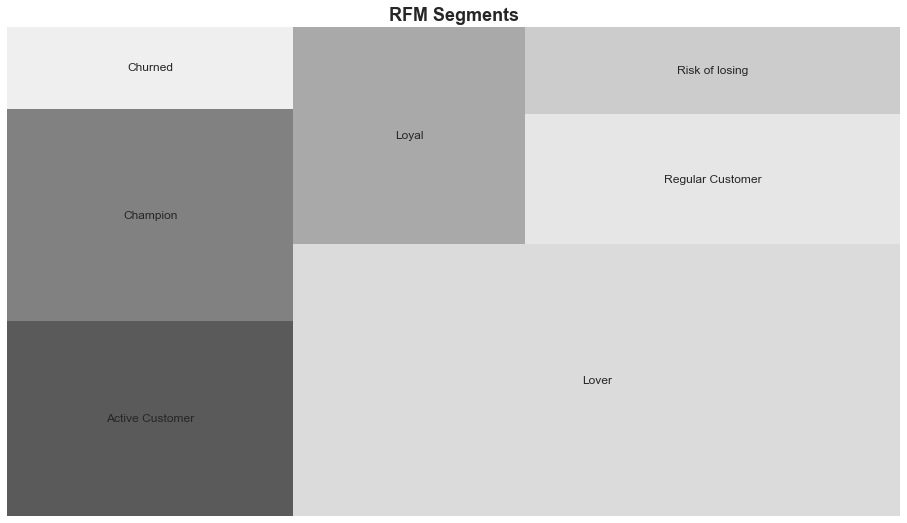

,Recency,Frequency,Monetary,Customers,RFMCatalog,Percent
0,41.4,14.7,149.5,286,Active Customer,12.78%
1,57.0,22.3,753.1,310,Champion,13.86%
2,85.9,11.7,38.9,121,Churned,5.41%
3,37.1,26.7,1106.3,843,Lover,37.68%
4,49.5,18.0,422.4,259,Loyal,11.58%
5,55.3,13.5,89.1,251,Regular Customer,11.22%
6,71.3,12.5,58.3,167,Risk of losing,7.47%


In [1242]:
#sns.pairplot(dts, vars=['Income','Recency','Spend','IncomePerCapita'], markers=['o','s']) 
rfm = dts

#Calculating R and F groups scores
r_range = range(4,0,-1)
f_range = range(1,5)
m_range = range(1,5)
#Cutting my base to fit my range (from - to)
r_group = pd.qcut(rfm['Recency'],q=4,labels=r_range)
f_group = pd.qcut(rfm['Purchases'],q=4,labels=f_range)
m_group = pd.qcut(rfm['Spend'],q=4,labels=m_range)
#assigning the values to my database
rfm = rfm.assign(R= r_group.values, F=f_group.values, M=m_group.values)
rfm['RFM'] = rfm[['R','F','M']].sum(axis=1)

#Lets categorize our customers in order to decrease the amount of categories
rfm.loc[(rfm['RFM'] >= 9), 'RFMCatalog'] = 'Lover'
rfm.loc[(rfm['RFM'] == 8), 'RFMCatalog'] = 'Champion'
rfm.loc[(rfm['RFM'] == 7), 'RFMCatalog'] = 'Loyal'
rfm.loc[(rfm['RFM'] == 6), 'RFMCatalog'] = 'Active Customer'
rfm.loc[(rfm['RFM'] == 5), 'RFMCatalog'] = 'Regular Customer'
rfm.loc[(rfm['RFM'] == 4), 'RFMCatalog'] = 'Risk of losing'
rfm.loc[(rfm['RFM'] < 4), 'RFMCatalog'] = 'Churned'

# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = rfm.groupby('RFMCatalog').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','ID':'count'}).round(1)
rfm_agg['RFMCatalog'] = rfm_agg.index
rfm_agg = rfm_agg.reset_index(drop=True, inplace=False)
rfm_agg = rfm_agg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

rfm_agg['Percent'] = (rfm_agg['Customers'] / rfm_agg['Customers'].sum()).map('{:,.2%}'.format)

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_agg['Customers'], 
              label=rfm_agg['RFMCatalog'], alpha=0.9 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()
rfm_agg

Having a look at our RFM Table it seems that the majority of our public is made out of the good layers (Loyal, Lover, Champion)
The most representative group is Lover. It seems very promising. 

Although we managed to classify our customers using this RFM table, there are many other possibilities of classification. Previously we noticed that the variable IncomePerCapita plays a role with Spend variable which has a correlation with some products categories.

# Model 2 - KMeans

### Factor Analysis

OBS: I failed at executing this analysis (maybe it needs more data modelling) and therefore I will proceed using RFM variables. If you wanna skip go further to KMeans chapter

Although we could proceed using the data from the RFM table, there's still too many variables and I have no idea which one is the right one to build our models (even if RFM is the right one).
Factor Analysis will be useful in finding the right variables because it describes the variability among correlated variables

<AxesSubplot:>

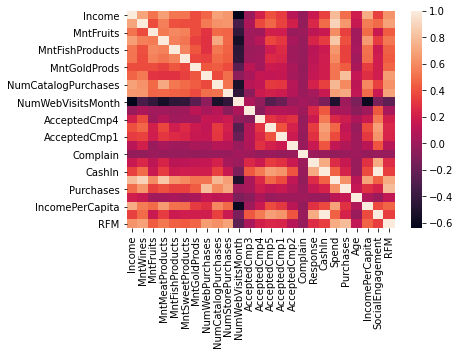

In [524]:
sns.heatmap(x.corr())

,0,1,2
0,0.801169,0.280065,0.173457
1,0.578305,0.475424,0.371991
2,0.657882,0.156766,0.004500
3,0.784843,0.159860,0.159367
4,0.689692,0.154977,0.006077
5,0.647229,0.166093,0.034592
6,0.420035,0.338255,0.086024
7,-0.327893,0.560216,-0.055562
8,0.270994,0.713812,0.113922
9,0.703515,0.339987,0.186605


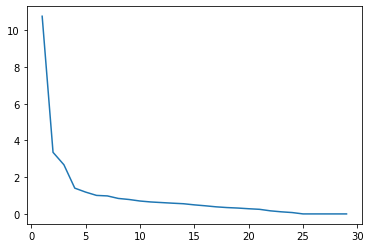

In [563]:
#We need to get rid of the string variables. I will not do the effort to givem them numbers 
#because our string variables(RFM and Education) apparently doesnt have a strong influence in our heatmap
x = rfm[rfm.columns[2:]]
#Dropping some columns that in order to improve the heatmap
x = x.drop(columns=['AOV','RFMCatalog','MonthlyIncome','Revenue','Relationship','Teenhome','Kidhome','Recency','HouseholdSize']) #We had to delete AOV too because of some calculum problems
#x['AOV'] = x['AOV'].astype('int64')

fa = FactorAnalyzer()
fa.fit(x, 10)

#Eigen values = how much of the variance of the variables does a factor explain

ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev) #Lets pick 4 since 1.4+4.1+3.2+2.1 = 10.8 variables explained.

#Rotation
fa = FactorAnalyzer(3, rotation='varimax') 
#Varimax maximizes the sum of the variance of squared loadings while ensuring that the factors created are not correlated 
fa.fit(x)
loads = fa.loadings_
xx = pd.DataFrame(loads)
xx.style.background_gradient(cmap='Blues')

Factor 1 = 20, 23, 27, 9, 3, 0 = Purchases, IncomePerCapita, M, NumCatalogPurhases, MntMeatProducts, Income

Factor 2 = 26, 21, 28, 8 = M, Purchases, RFM, NumWebPurchases

Factor 3 = 19, 24, 18 = CashIn, SocialEngagement, Response

In [562]:
factor1 = x[['Purchases','IncomePerCapita','M','NumCatalogPurchases','MntMeatProducts','Income']]
factor2 = x[['M','Purchases','RFM','NumWebPurchases']]
factor3 = x[['CashIn','SocialEngagement','Response']]

factor1['M'] = factor1['M'].astype('int64')
factor2['M'] = factor2['M'].astype('int64')

#Get cronbach alpha <- used to measure if the variables are coherent or not
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
print(factor1_alpha, factor2_alpha, factor3_alpha)

(0.5135217878019968, array([0.482, 0.544])) (0.8098981782710597, array([0.796, 0.823])) (0.11587555428117652, array([0.05 , 0.177]))


<ipython-input-562-281c50578156>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor1['M'] = factor1['M'].astype('int64')
<ipython-input-562-281c50578156>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor2['M'] = factor2['M'].astype('int64')


The factors given didnt get a significant result (+65) on cronbach alpha and therefore it failed. I believe it would take a little bit more modelling to get the Factor Analysis good but since I dont have much time I'll proceed using the RFM variables.

### KMeans


<AxesSubplot:>

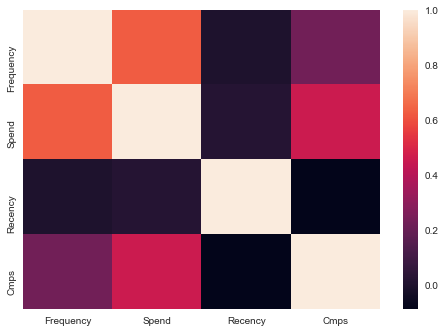

In [1148]:
#Lets have a look at our variables. There's a detail: since we need to find the
#best customers in valuation terms, they also need to respond to our campaigns
#so we need to add the value communication in it
rfm['Cmps'] = dataset['AcceptedCmp1']+dataset['AcceptedCmp2']+dataset['AcceptedCmp3']+dataset['AcceptedCmp4']+dataset['AcceptedCmp5']+dataset['Response']
km = rfm[['ID','Purchases','Spend','Recency','Cmps']]
km = km.rename(columns={'Purchases':'Frequency'})

sns.heatmap(km.iloc[:,1:].corr())

<AxesSubplot:>

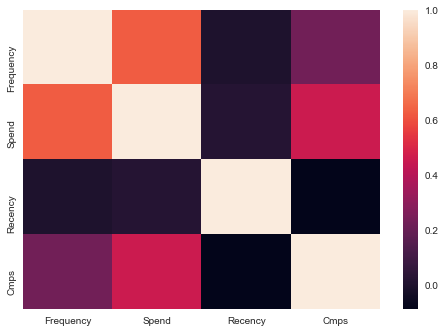

In [1149]:
#Since i didnt normalize the values during the cleaning steps, I'll do it now
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
kmnorm = pd.DataFrame(scaler.fit_transform(km.iloc[:,1:]))
kmnorm.columns = ['Frequency','Spend','Recency','Cmps']
kmnorm

sns.heatmap(kmnorm.corr())

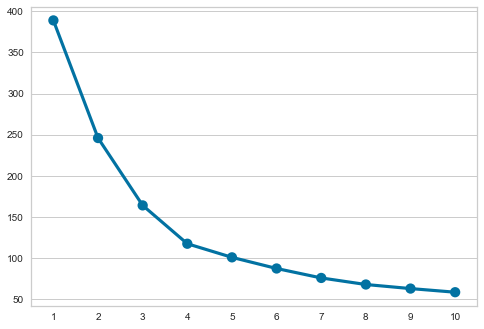

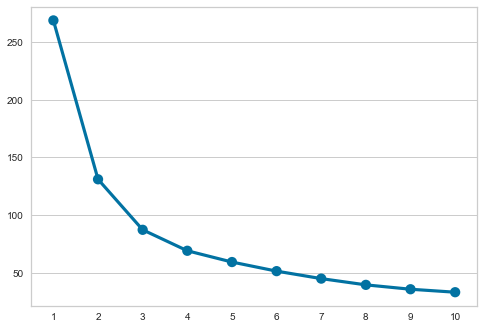

In [1150]:
#Now we gotta segment identifying the optimal K
from sklearn.cluster import KMeans

SSE = []
for k in range(0,10):
    kmeans= KMeans(n_clusters=k+1, random_state=1231).fit(kmnorm.iloc[:,:3])
    SSE.append(kmeans.inertia_)
    

sns.pointplot(x=list(range(1,11)),y=SSE)
plt.show()

#Second plot for kmeans using our Cmps variable
SSE2 = []
for k in range(0,10):
    kmeans2= KMeans(n_clusters=k+1, random_state=1231).fit(kmnorm[['Frequency','Spend','Cmps']])
    SSE2.append(kmeans2.inertia_)

sns.pointplot(x=list(range(1,11)),y=SSE2)
plt.show()

Taking a look at the graph I would pick k=5 in both cases, but just for a double check I will run a test to see if this number is reasonable.

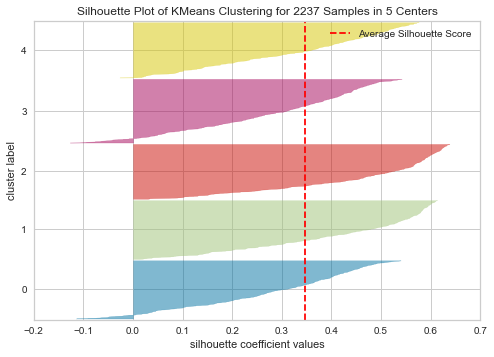

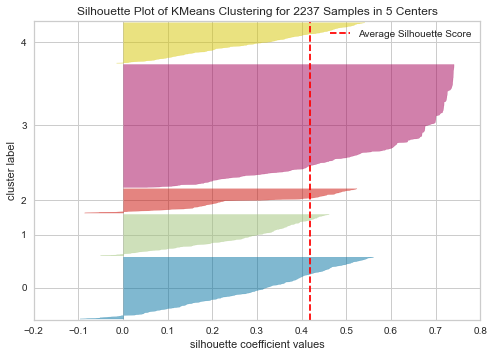

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2237 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=42))

In [1118]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(KMeans(5, random_state=42), kmnorm.iloc[:,:3], colors='yellowbrick')

silhouette_visualizer(KMeans(5, random_state=42), kmnorm[['Frequency','Spend','Cmps']], colors='yellowbrick')

<AxesSubplot:>

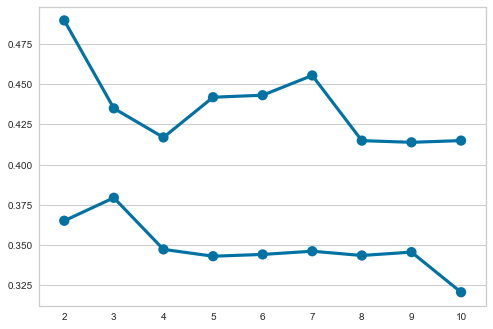

In [1151]:
silcoe = []
from sklearn.metrics import silhouette_score

for k in range(2,11):
    kmeans2 = KMeans(n_clusters=k+1, random_state=1231).fit(kmnorm.iloc[:,:3])
    score = silhouette_score(kmnorm.iloc[:,:3], kmeans2.labels_)
    silcoe.append(score)

sns.pointplot(x=list(range(2,11)),y=silcoe)

silcoe2 = []
for k in range(2,11):
    kmeans2 = KMeans(n_clusters=k+1, random_state=1231).fit(kmnorm[['Frequency','Spend','Cmps']])
    score = silhouette_score(kmnorm[['Frequency','Spend','Cmps']], kmeans2.labels_)
    silcoe2.append(score)

sns.pointplot(x=list(range(2,11)),y=silcoe2)

After running different combinations of k=(1:10) in the silhouette_visualizer, the best combination for both cases, based on the common appearence of the clusters, indeed is 5

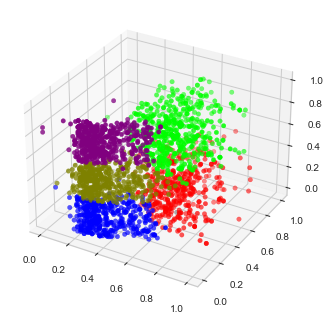

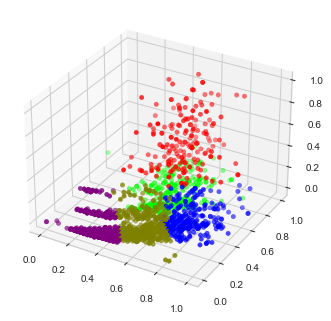

In [1152]:
model = KMeans(n_clusters=5,random_state=1231).fit(kmnorm.iloc[:,:3])
centers= model.cluster_centers_
fig = plt.figure()
#rfm_norm.iloc[:,:3]
ax= fig.add_subplot(111, projection='3d')
ax.scatter(kmnorm['Frequency'], kmnorm['Spend'], kmnorm['Recency'], cmap='brg',
           c=model.predict(kmnorm[['Frequency','Spend','Recency']]))
ax.scatter(centers[:,0], centers[:,1], c='black')

model2 = KMeans(n_clusters=5,random_state=1231).fit(kmnorm[['Frequency','Spend','Cmps']])
centers= model2.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmnorm['Frequency'], kmnorm['Spend'], kmnorm['Cmps'], cmap='brg',
           c=model2.predict(rfm_norm[['Frequency','Spend','Cmps']]))
ax.scatter(centers[:,0], centers[:,1], c='black')

#I love 3d graphs and you?

C:\Users\felip\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


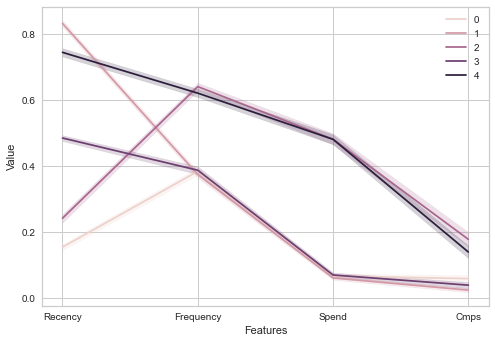

In [1157]:
#aux = pd.DataFrame(scaler.inverse_transform(rfm_norm))
#aux.columns = rfm_norm.columns
#aux['ID'] = rfm2['ID']
#aux['Cluster'] = model.labels_
#aux = aux[aux['Cluster'] < 3]

rfm_norm['ID'] = rfm2['ID']
rfm_norm['Cluster'] = model.labels_

melted_rfm = pd.melt(rfm_norm.reset_index(),
                    id_vars=['ID','Cluster'],
                    value_vars=['Recency','Frequency','Spend','Cmps'],
                     var_name='Features',
                     value_name='Value')
sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm)
plt.legend()

Olhando para os resultados que obtivemos utilizando os valores de estrutura de RFM, encontramos 5 grupos. O cluster mais valioso é o 2.

Cluster 1 (0) -> Clientes de recencia recente, numero de compras pouco abaixo da média, Spending baixo e baixo engajamento. Cliente novo.

Cluster 2 (1) -> Clientes de recencia longinqua alta, numero de compras médio , spending baixo e baixo engajamento. Churned.

Cluster 3 (2) -> Clientes de recencia recente, numero alto de compras, spending alto e é o mmais engajado. Cliente mais valioso.

Cluster 4 (3) -> Clientes de recencia longinqua, numero de compras médio, spending baixo e pouco engajado. Cliente maduro desengajado.

Cluster 5 (4) -> Clientes de recencia longinqua, numero de compras alto, spending alto e ligeiramente engajado. Churned valioso engajado.

C:\Users\felip\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


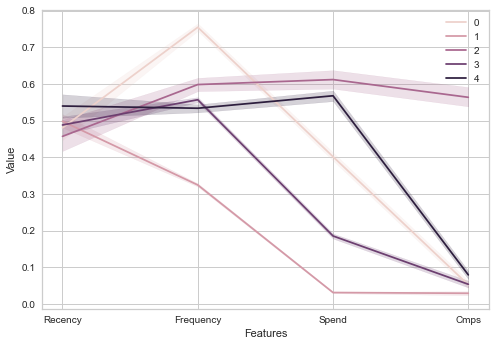

In [1178]:
ax = kmnorm
ax['ID'] = km['ID']
ax['Cluster'] = model2.labels_

melted_rfm = pd.melt(ax.reset_index(),
                    id_vars=['ID','Cluster'],
                    value_vars=['Recency','Frequency','Spend','Cmps'],
                     var_name='Features',
                     value_name='Value')
sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm)
plt.legend()

Apparently recency is spread equally throughout the clusters, and it seems like they all have a recency of more or less 30 days. The cluster 2 is our most valuable consumer.

Cluster 1 (0) -> Highest Frequency, medium Spending and low engagement. Loyal Customer.

Cluster 2(1) -> Lowest Frequency, lowest Spending and low engagement. Price Sensitive client.

Cluster 3(2) -> High Frequency, Highest Spending and Highest engagement. Most valuable engaged client.

Cluster 4(3) -> Medium Frequency, Low Spending and low engagement. Matured Client

Cluster 5(4) -> Medium Frequency, High Spending and low engagement. Most valuable not engaged client.

# Segmenting our base

## Model 1 - RFM + KMeans 

Now that we have encountered 2 clusterization tha appears to be much more reazonable than the RFM classification that we did by hand, it is time to get some insights from our base. Let's begin by classifying our first model.

In [1536]:
rfm['RFMCluster'] = model.labels_
rfm['FMECluster'] = model2.labels_
rfm['Cmps'] = dataset['AcceptedCmp1']+dataset['AcceptedCmp2']+dataset['AcceptedCmp3']+dataset['AcceptedCmp4']+dataset['AcceptedCmp5']+dataset['Response']

In [1509]:
# Calculate average values for each RFM_Level, and return a size of each segment 
kmagg = rfm.groupby('RFMCluster').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
kmagg['RFMCluster'] = kmagg.index
kmagg = kmagg.reset_index(drop=True, inplace=False)
kmagg = kmagg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

kmagg['Percent'] = (kmagg['Customers'] / kmagg['Customers'].sum()).map('{:,.2%}'.format)
kmagg

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,RFMCluster,Percent
0,15.3,15.9,171.2,0.3,439,8.0,15596.0,2.8,0,19.62%
1,82.5,15.5,156.1,0.1,434,8.0,14977.5,2.9,1,19.40%
2,23.9,26.6,1211.2,0.9,448,8.1,37616.6,2.3,2,20.03%
3,48.0,16.1,178.6,0.2,426,8.0,14755.2,2.9,3,19.04%
4,73.8,25.8,1211.1,0.7,490,8.2,38189.9,2.2,4,21.90%


It seems that our clustering split the base evenly among the clusters. 

Cluster 0 are Fresh Consumers with a low Frequency and low Monetary. They dont engage in our campaigns as well.

Cluster 1 has a similar beheavior of the cluster 1 but has a much higher Recency. We could say that these are churned.

Cluster 2 has a moderate recency but they have the biggest frequency, monetary, Cmps, 2nd biggest IncomePerCapita, and 2nd lowest HouseholdSize, I'd say that these are the most Valuable Customers. They're matured clients that frequently buy our products and most of them have a partner to live with.

Cluster 3 is similar to the clusters 0 and 1 although they have a more recent Recency. I'd say that they are the less valuable active clients.

Cluster 4 is similar to the Cluster 2 despite for it's recency being the 2nd biggest among the clusters. I'd classify them as inactive valuable customers.

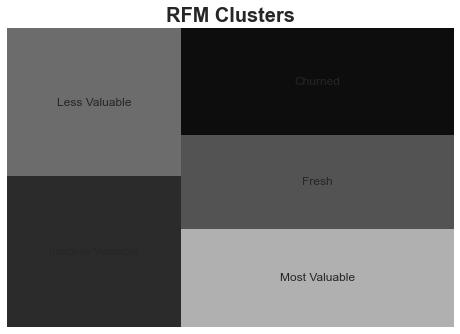

In [1510]:
#Lets categorize our customers in order to decrease the amount of categories
rfm.loc[(rfm['RFMCluster'] == 0), 'ModelLabel'] = 'Fresh'
rfm.loc[(rfm['RFMCluster'] == 1), 'ModelLabel'] = 'Churned'
rfm.loc[(rfm['RFMCluster'] == 2), 'ModelLabel'] = 'Most Valuable'
rfm.loc[(rfm['RFMCluster'] == 3), 'ModelLabel'] = 'Less Valuable'
rfm.loc[(rfm['RFMCluster'] == 4), 'ModelLabel'] = 'Inactive Valuable'

kmagg.loc[(rfm['RFMCluster'] == 0), 'ModelLabel'] = 'Fresh'
kmagg.loc[(rfm['RFMCluster'] == 1), 'ModelLabel'] = 'Churned'
kmagg.loc[(rfm['RFMCluster'] == 2), 'ModelLabel'] = 'Most Valuable'
kmagg.loc[(rfm['RFMCluster'] == 3), 'ModelLabel'] = 'Less Valuable'
kmagg.loc[(rfm['RFMCluster'] == 4), 'ModelLabel'] = 'Inactive Valuable'

#Create our plot and resize it.
fig2 = plt.gcf()
ax2 = fig2.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=kmagg['Customers'], 
              label=kmagg['ModelLabel'])
plt.title("RFM Clusters",fontsize=20,fontweight="bold")
plt.axis('off')
plt.show()

Now we need to take a look at how this clustering behaves within those that converted in the last campaign

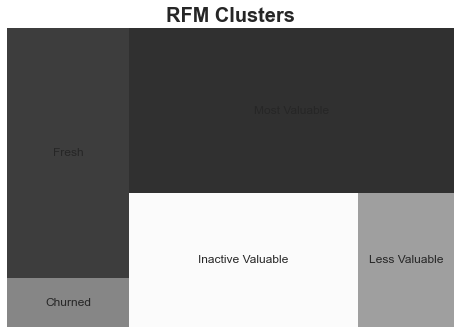

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,ModelLabel,Percent
0,79.2,20.0,233.5,1.4,15,8.7,14561.9,2.9,Churned,4.49%
1,11.6,18.4,186.8,1.4,76,8.2,14706.3,2.7,Fresh,22.75%
2,71.6,25.9,1499.3,2.5,77,8.4,52665.3,1.8,Inactive Valuable,23.05%
3,46.7,18.2,209.8,1.6,32,8.6,16118.6,2.5,Less Valuable,9.58%
4,20.5,25.4,1417.1,2.2,134,8.3,51252.1,1.8,Most Valuable,40.12%


In [1511]:
resp = rfm[rfm['Response']==1]

# Calculate average values for each RFM_Level, and return a size of each segment 
respagg = resp.groupby('ModelLabel').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
respagg['ModelLabel'] = respagg.index
respagg = respagg.reset_index(drop=True, inplace=False)
respagg = respagg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

respagg['Percent'] = (respagg['Customers'] / respagg['Customers'].sum()).map('{:,.2%}'.format)
respagg

#Create our plot and resize it.
fig2 = plt.gcf()
ax2 = fig2.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=respagg['Customers'], 
              label=respagg['ModelLabel'])
plt.title("RFM Clusters",fontsize=20,fontweight="bold")
plt.axis('off')
plt.show()
respagg

Most of our client base that did respond to our last campaign is part of the Most Valuable Cluster! Great! The biggest groups are respectivally Most Valuable, Inactive Valuable Customer, and Fresh. 

The customers that bought in the last 30 days and converted in our sixth campaign, ~62% of those customers are New or Most Valuable.

The second biggest group, Inactive Valuable Customer is the most engaged group in our campaigns. Probably the last campaigns failed at activing this customer. We must work to active them since they have similar Frequency, Monetary and Engagement with the Most Valuable Customers.

Despite for the appearences the Most Valuable and Inactive Valuable Customers in this cut have some differences with the rest of the customers in the same cluster as them. Their householdSize mean is <2 while the majority of the cluster is >2 and therefore the IncomePerCapita is significantly bigger (~20K). I'd say that these are Premium Customers.

## Model 2 - FME + KMeans 

In [1512]:
# Calculate average values for each RFM_Level, and return a size of each segment 
kmagg = rfm.groupby('FMECluster').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean','Age':'mean'}).round(1)
kmagg['FMECluster'] = kmagg.index
kmagg = kmagg.reset_index(drop=True, inplace=False)
kmagg = kmagg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

kmagg['Percent'] = (kmagg['Customers'] / kmagg['Customers'].sum()).map('{:,.2%}'.format)
kmagg

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,Age,FMECluster,Percent
0,47.6,31.3,1011.4,0.3,310,8.3,26959.2,2.7,56.0,0,13.86%
1,49.3,13.5,83.1,0.1,945,7.9,13254.8,2.9,50.7,1,42.24%
2,45.3,24.8,1538.5,2.8,187,8.1,49071.4,1.9,52.6,2,8.36%
3,48.3,23.1,469.7,0.3,480,8.1,21356.8,2.8,55.0,3,21.46%
4,53.4,22.2,1427.8,0.4,315,8.1,47260.5,1.8,54.7,4,14.08%


Unfortunatelly in this model most of it is made out of Imature Customers. Our best group represents only 8% of our database.Comparing the variable's mean's of each group, most of them have the same Frequency except for Imature Customers, and similar Recency.

Cluster 0 has the biggest frequency, 3th biggest and expressive Monetary. They have a HouseholdSize >2.5 and therefore I'd categorize them as Active Customer since they probably have children and a partner and thus might have a higher need for constantly purchases.

Cluster 1 has the lowest scores at every valuable. Id categorize them as less valuable.

Cluster 2 which has the 2nd biggest Frequency, best Cmps, Monetary and IncomeperCapita. He also has a HouseholdSize <2.

Cluster 3 are between Cluster 1 and 0, probably maturing to become an Active Customer and thus will be categorized as such.

Cluster 4 share similar features with Cluster 2 except for Cmps. I'd theyre valuable customers that didnt convert in the majority of our last campaigns and must be targeted. 

Cluster 4 + Cluster 2 would make up to ~22% of the base.

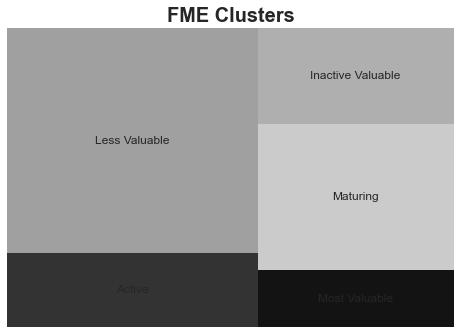

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,Age,FMECluster,Percent,Model2Label
0,47.6,31.3,1011.4,0.3,310,8.3,26959.2,2.7,56.0,0,13.86%,Active
1,49.3,13.5,83.1,0.1,945,7.9,13254.8,2.9,50.7,1,42.24%,Less Valuable
2,45.3,24.8,1538.5,2.8,187,8.1,49071.4,1.9,52.6,2,8.36%,Most Valuable
3,48.3,23.1,469.7,0.3,480,8.1,21356.8,2.8,55.0,3,21.46%,Maturing
4,53.4,22.2,1427.8,0.4,315,8.1,47260.5,1.8,54.7,4,14.08%,Inactive Valuable


In [1513]:
#Lets categorize our customers in order to decrease the amount of categories
rfm.loc[(rfm['FMECluster'] == 0), 'Model2Label'] = 'Active'
rfm.loc[(rfm['FMECluster'] == 1), 'Model2Label'] = 'Less Valuable'
rfm.loc[(rfm['FMECluster'] == 2), 'Model2Label'] = 'Most Valuable'
rfm.loc[(rfm['FMECluster'] == 3), 'Model2Label'] = 'Maturing'
rfm.loc[(rfm['FMECluster'] == 4), 'Model2Label'] = 'Inactive Valuable'

kmagg.loc[(kmagg['FMECluster'] == 0), 'Model2Label'] = 'Active'
kmagg.loc[(kmagg['FMECluster'] == 1), 'Model2Label'] = 'Less Valuable'
kmagg.loc[(kmagg['FMECluster'] == 2), 'Model2Label'] = 'Most Valuable'
kmagg.loc[(kmagg['FMECluster'] == 3), 'Model2Label'] = 'Maturing'
kmagg.loc[(kmagg['FMECluster'] == 4), 'Model2Label'] = 'Inactive Valuable'


#Create our plot and resize it.
fig2 = plt.gcf()
ax2 = fig2.add_subplot()
fig.set_size_inches(60, 120)
squarify.plot(sizes=kmagg['Customers'], 
              label=kmagg['Model2Label'])
plt.title("FME Clusters",fontsize=20,fontweight="bold")
plt.axis('off')
plt.show()
kmagg

Now we need to take a look at how this clustering behaves within those that converted in the last campaign

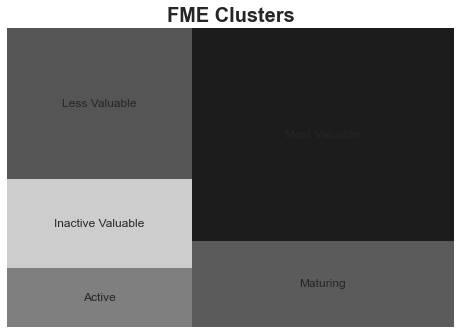

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,Model2Label,Percent
0,35.0,32.4,991.1,1.2,27,8.7,32315.5,2.4,Active,8.08%
1,37.8,22.5,1508.0,1.0,41,8.4,61632.8,1.4,Inactive Valuable,12.28%
2,26.2,14.8,82.0,1.3,70,8.2,12687.0,2.6,Less Valuable,20.96%
3,32.7,23.9,373.1,1.3,56,8.6,17688.6,2.8,Maturing,16.77%
4,40.4,25.1,1532.4,3.0,140,8.2,53548.5,1.8,Most Valuable,41.92%


In [1514]:
resp = rfm[rfm['Response']==1]

# Calculate average values for each RFM_Level, and return a size of each segment 
respagg = resp.groupby('Model2Label').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
respagg['Model2Label'] = respagg.index
respagg = respagg.reset_index(drop=True, inplace=False)
respagg = respagg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

respagg['Percent'] = (respagg['Customers'] / respagg['Customers'].sum()).map('{:,.2%}'.format)

#Create our plot and resize it.
fig2 = plt.gcf()
ax2 = fig2.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=respagg['Customers'], 
              label=respagg['Model2Label'])
plt.title("FME Clusters",fontsize=20,fontweight="bold")
plt.axis('off')
plt.show()
respagg

Yaykees! Strike again! :)

Within those that converted in our last campaign, the majority of them (41%) are composed by our Most Valuable Customer cluster, and if we count the Inactive Valuable Customer the percentage increases to ~53%!

It looks like our groups of Valuable Customers have again HouseholdSize <2 and therefore the biggest IncomePerCapita.

An interesting insight is that the last campaign actived most of the Inactive Valuable Customers for the first since (since their mean Cmps = 1), and they represent 12% of our base! 

## Model 1 + Model 2 

Lets have a look at what our 2 models combined can provide us in terms of information

In [1515]:
#resp = rfm[rfm['Response']==1] 
resp=rfm[rfm['RFMCluster']==2]
#resp=resp[resp['FMECluster']==2]

# Calculate average values for each RFM_Level, and return a size of each segment 
#respagg = resp.groupby('Model2Label','ModelLabel').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
#respagg
# Calculate average values for each RFM_Level, and return a size of each segment 
respagg = resp.groupby(['RFMCluster','FMECluster']).agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
respagg['RFMxFME'] = respagg.index
respagg = respagg.reset_index(drop=True, inplace=False)
respagg = respagg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

respagg['Percent'] = (respagg['Customers'] / respagg['Customers'].sum()).map('{:,.2%}'.format)

respagg

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,RFMxFME,Percent
0,25.7,31.5,1005.9,0.3,167,8.3,27441.5,2.7,"(2, 0)",37.28%
1,21.9,24.7,1574.2,2.8,99,8.1,51279.2,1.9,"(2, 2)",22.10%
2,25.0,25.3,670.7,0.2,58,8.0,24394.9,2.7,"(2, 3)",12.95%
3,22.7,22.2,1450.6,0.5,124,8.1,46596.7,1.9,"(2, 4)",27.68%


Great! Here we are combining both RFM and FME clusterization, both specifically inside of RFM Most Valuable cluster.

It looks like ~50% is composed of FME cluster 2 and 4 (remembering theyre respectivally Most Valuable Customer and Inactive Most Valuable Customer). This is an important information since we could this combination to create a Prime Customer category.

In [1516]:
#resp = rfm[rfm['Response']==1] 
#resp=rfm[rfm['RFMCluster']==2]
resp=rfm[rfm['FMECluster']==2]

# Calculate average values for each RFM_Level, and return a size of each segment 
#respagg = resp.groupby('Model2Label','ModelLabel').agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
#respagg
# Calculate average values for each RFM_Level, and return a size of each segment 
respagg = resp.groupby(['FMECluster','RFMCluster']).agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','IncomePerCapita':'mean','HouseholdSize':'mean'}).round(1)
respagg['FMExRFM'] = respagg.index
respagg = respagg.reset_index(drop=True, inplace=False)
respagg = respagg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

respagg['Percent'] = (respagg['Customers'] / respagg['Customers'].sum()).map('{:,.2%}'.format)

respagg

,Recency,Frequency,Monetary,Cmps,Customers,Relationship,IncomePerCapita,HouseholdSize,FMExRFM,Percent
0,2.0,25.0,409.0,3.0,2,7.0,20326.0,2.5,"(2, 0)",1.07%
1,21.9,24.7,1574.2,2.8,99,8.1,51279.2,1.9,"(2, 2)",52.94%
2,50.8,21.2,587.2,3.0,4,8.2,44947.2,1.5,"(2, 3)",2.14%
3,74.2,25.2,1569.3,2.8,82,8.2,47308.3,2.0,"(2, 4)",43.85%


The match here is much incredibly higher! Our FME model is composed mainly of Most Valuable and Inactive Most Valuable customers from RFM model. 

We may conclude that a combination of the best clusters of RME + FME will give us a new cluster that will be composed mainly of high value customers that are engaged.

A sub category of this custer will be composed of the Inactive Value Customers, and this will be done in order to show the importance of not losing the engagement of such customers.

In [1537]:
rfm['FinalCluster'] = rfm['ModelLabel']

#The preference for being identified as Prime Customer will be for FMECluster.

rfm.loc[(rfm['RFMCluster']==2) & (rfm['FMECluster']==2),'FinalCluster'] = 'Prime'
rfm.loc[(rfm['RFMCluster']==4) & (rfm['FMECluster']==2),'FinalCluster'] = 'Prime'
rfm.loc[(rfm['RFMCluster']==2) & (rfm['FMECluster']==4),'FinalCluster'] = 'Pre-Prime'
rfm.loc[(rfm['RFMCluster']==4) & (rfm['FMECluster']==4),'FinalCluster'] = 'Pre-Prime'


In [1540]:
agg = rfm.groupby(['FinalCluster']).agg({'Recency': 'mean','Purchases': 'mean','Spend': 'mean','Cmps':'mean','ID':'count','Relationship':'mean','Age':'mean','IncomePerCapita':'mean','HouseholdSize':'mean','RFM':'mean','RFMCluster':'mean','FMECluster':'mean'}).round(1)
agg['FinalCluster'] = agg.index
agg = agg.reset_index(drop=True, inplace=False)
agg = agg.rename(columns={'Purchases':'Frequency','Spend':'Monetary','ID':'Customers'})

agg['Percent'] = (agg['Customers'] / agg['Customers'].sum()).map('{:,.2%}'.format)
agg


,Recency,Frequency,Monetary,Cmps,Customers,Relationship,Age,IncomePerCapita,HouseholdSize,RFM,RFMCluster,FMECluster,FinalCluster,Percent
0,82.5,15.5,156.1,0.1,434,8.0,51.5,14977.5,2.9,4.6,1.0,1.5,Churned,19.40%
1,15.3,15.9,171.2,0.3,439,8.0,51.7,15596.0,2.8,7.3,0.0,1.6,Fresh,19.62%
2,73.4,29.0,899.4,0.2,221,8.2,56.7,26501.1,2.7,8.6,4.0,1.1,Inactive Valuable,9.88%
3,48.0,16.1,178.6,0.2,426,8.0,52.3,14755.2,2.9,6.1,3.0,1.6,Less Valuable,19.04%
4,25.5,29.9,919.5,0.3,225,8.2,55.5,26656.1,2.7,10.6,2.0,0.8,Most Valuable,10.06%
5,53.6,22.3,1433.7,0.4,311,8.1,54.6,47443.8,1.8,9.1,3.2,4.0,Pre-Prime,13.90%
6,45.6,24.9,1572.0,2.8,181,8.1,52.4,49480.2,1.9,9.9,2.9,2.0,Prime,8.09%


In [1544]:
#Now i will create the final dataset and delete from it the columns that wont
#be used by the final user of this project. 
dts2 = rfm
dts2 = dts2.drop(columns=['RFMCluster','FMECluster','Cmps','RFMCatalog','RFM'])
dts2

,ID,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,MonthlyIncome,HouseholdSize,IncomePerCapita,SocialEngagement,R,F,M,ModelLabel,Model2Label,FinalCluster
0,5524,Graduation,58138.0,0,0,58,635,88,546,172,...,4845,1,58138,0.17,2,4,4,Inactive Valuable,Inactive Valuable,Pre-Prime
1,2174,Graduation,46344.0,1,1,38,11,1,6,2,...,3862,3,15448,0.00,3,1,1,Less Valuable,Less Valuable,Less Valuable
2,4141,Graduation,71613.0,0,0,26,426,49,127,111,...,5968,2,35806,0.00,3,3,3,Most Valuable,Maturing,Most Valuable
3,6182,Graduation,26646.0,1,0,26,11,4,20,10,...,2220,3,8882,0.00,3,1,1,Fresh,Less Valuable,Fresh
4,5324,PhD,58293.0,1,0,94,173,43,118,46,...,4858,3,19431,0.00,1,3,3,Churned,Maturing,Churned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduation,61223.0,0,1,46,709,43,182,42,...,5102,3,20408,0.00,3,3,4,Most Valuable,Inactive Valuable,Pre-Prime
2236,4001,PhD,64014.0,2,1,56,406,0,30,0,...,5334,5,12803,0.17,2,4,3,Less Valuable,Maturing,Less Valuable
2237,7270,Graduation,56981.0,0,0,91,908,48,217,32,...,4748,1,56981,0.17,1,3,4,Inactive Valuable,Inactive Valuable,Pre-Prime
2238,8235,Master,69245.0,0,1,8,428,30,214,80,...,5770,3,23082,0.00,4,4,3,Most Valuable,Active,Most Valuable


So far we have:

-> Cleaned the data & modell it

-> Explored our customer characteristics

-> Used 3 models to segment our customer base: RFM, RFM + KMeans, FME + Kmeans

-> We discarted the RFM model for being largely influenced by myself and decided to stick to more mathematical and sophisticated models.

-> We created a deviation model from the RFM+Kmeans called FME which stands for Frequency, Monetary, Engagement (this last variable being associated to the customer engagement with our campaigns)

-> We combined the RFM+Kmeans with FME+KMeans to find the best customers and created a new clustering called Prime and Pre-Prime, both with high rentability and suspectible to our campaigns.

I will load the new dataset to a .csv file, upload it on Google Sheets in order to make the graphs for our presentation. This way the graphs on Google Presentation will be linked to this Google Sheets, and if my Business Client wants to check the data by himself he can easily access all the information.

In [1546]:
dts2.to_csv(r'C:\Users\felip\Desktop\IFOOD\ifoodTreated.csv', index = False)